# Hacking DCGAN

In this section, we will attempt to make attacks against a pretrained DCGAN taken from https://github.com/csinva/gan-pretrained-pytorch/tree/master/mnist_dcgan. 

We will test white-box attacks against the model as well as black-box attacks with leakages. 

In [1]:
import os
import torch
import torchvision
import torch.nn as nn
from torchvision import transforms
from torchvision.utils import save_image
from torch.autograd import Variable
import matplotlib.pyplot as plt
import pylab
import numpy as np
%load_ext autoreload
%autoreload 2

In [2]:
import os

GDRIVE_PATH = '/data/apsidorenko'
THIS_EXERCISE_PATH = os.path.join(GDRIVE_PATH, "GAN_exercises")
MODELS_HOME = os.path.join(THIS_EXERCISE_PATH, "mnist guns")

In [3]:
os.makedirs(THIS_EXERCISE_PATH, exist_ok=True)
os.makedirs(MODELS_HOME, exist_ok=True)

In [4]:
num_gpu = 1 if torch.cuda.is_available() else 0

# load the models
from dcgan import Discriminator, Generator

D = Discriminator(ngpu=1).eval()
G = Generator(ngpu=1).eval()

# load weights
D.load_state_dict(torch.load('weights/netD_epoch_99.pth'))
G.load_state_dict(torch.load('weights/netG_epoch_99.pth'))
if torch.cuda.is_available():
    D = D.cuda()
    G = G.cuda()

# generate some images

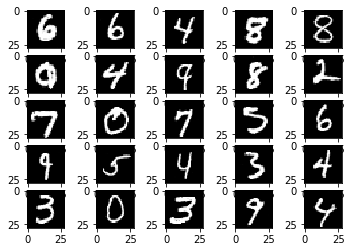

In [5]:
batch_size = 25
latent_size = 100

fixed_noise = torch.randn(batch_size, latent_size, 1, 1)
if torch.cuda.is_available():
    fixed_noise = fixed_noise.cuda()
fake_images = G(fixed_noise)


# z = torch.randn(batch_size, latent_size).cuda()
# z = Variable(z)
# fake_images = G(z)

fake_images_np = fake_images.cpu().detach().numpy()
fake_images_np = fake_images_np.reshape(fake_images_np.shape[0], 28, 28)
R, C = 5, 5
for i in range(batch_size):
    plt.subplot(R, C, i + 1)
    plt.imshow(fake_images_np[i], cmap='gray')
plt.show()

# run discriminator

In [6]:
outputs = D(fake_images)
print(outputs)

tensor([0.1279, 0.5783, 0.0323, 0.5865, 0.0629, 0.0360, 0.2176, 0.0132, 0.3437,
        0.2541, 0.0568, 0.0022, 0.3698, 0.0111, 0.2376, 0.1719, 0.4661, 0.2838,
        0.7501, 0.1911, 0.5185, 0.0115, 0.0358, 0.3414, 0.0855],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


# Black-box attack

In [7]:
from torch.nn.functional import logsigmoid

In [8]:
LEAK_SHARE = 0.2 #how much elements have been delivered to an adversary

In [9]:
import pandas as pd

In [10]:
df = pd.read_csv('https://query.data.world/s/nap7jvxtupud25z5ljvtbzzjjsqqay')
df.head()

,column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8,column_9,...,column_774,column_775,column_776,column_777,column_778,column_779,column_780,column_781,column_782,column_783
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
target = pd.read_csv('https://query.data.world/s/sn3dximsq5sw3a6wtqoc3okulevugz')
target.head()

,column_0
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0


In [12]:
from sklearn.model_selection import train_test_split
train, test, tar_train, tar_test = train_test_split(df, target, test_size=0.2, random_state=12345)

In [13]:
train = np.array(train, dtype='float')
test = np.array(test, dtype='float')
tar_train = np.array(tar_train, dtype='float')
tar_test = np.array(tar_test, dtype='float')

In [14]:
train= train.reshape((-1, 1, 28, 28)) / 255.
test= test.reshape((-1, 1, 28, 28)) / 255.

In [15]:
n_leak = round(LEAK_SHARE * train.shape[0])

In [16]:
train_leak = train[np.random.permutation(train.shape[0])]
train_check = train_leak[n_leak:]
train_leak = train_leak[0:n_leak]

In [111]:
class Reshape(torch.nn.Module):
  """
  Reshapes a tensor starting from the 1st dimension (not 0th),
  i. e. without influencing the batch dimension.
  """
  def __init__(self, *shape):
    super(Reshape, self).__init__()
    self.shape = shape

  def forward(self, x):
    return x.view(x.shape[0], *self.shape)
  
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.shape[0], -1)

In [112]:
DROPOUT_RATE = 0.1
discriminator = nn.Sequential(
           #Reshape(1, 28,28),
           torch.nn.Conv2d(1, 8, kernel_size=3, padding=1),
           torch.nn.ELU(),
           torch.nn.Dropout(p=DROPOUT_RATE),
      
            torch.nn.MaxPool2d(2), # 18x18
      
            torch.nn.Conv2d(8, 32, kernel_size=3, padding=1),
            torch.nn.ELU(),
            torch.nn.Dropout(p=DROPOUT_RATE),
      
            torch.nn.MaxPool2d(2), # 9x9
      
            torch.nn.Conv2d(32, 64, kernel_size=3), # 7x7
            torch.nn.ELU(),
            torch.nn.Dropout(p=DROPOUT_RATE),
      
            torch.nn.Conv2d(64, 256, kernel_size=3), # 5x5
            torch.nn.ELU(),
            torch.nn.Dropout(p=DROPOUT_RATE),
      
            torch.nn.Conv2d(256, 512, kernel_size=3), # 3x3
            torch.nn.ELU(),
            torch.nn.Dropout(p=DROPOUT_RATE),
      
             Reshape(512),
             torch.nn.Linear(512, 1)
).cuda()

In [113]:
import os

GDRIVE_PATH = '/data/apsidorenko'
THIS_EXERCISE_PATH = os.path.join(GDRIVE_PATH, "GAN_exercises")
MODELS_HOME = os.path.join(THIS_EXERCISE_PATH, "mnist guns")

In [114]:
DISCRIMINATOR_FILE = os.path.join(MODELS_HOME, 'discriminator_dcgan_bamboo.pt')

In [115]:
def sample_fake(batch_size):
  noise = torch.randn(batch_size, latent_size, 1, 1, device="cuda")
  return G(noise)

In [116]:
def sample_images(batch_size, train=train):
  ids = np.random.choice(len(train), size=batch_size)
  return torch.tensor(train[ids], device="cuda").float()

In [117]:
noise_power = 0.2
gradient_penalty = 0.0001


  
def discriminator_loss(real, fake):
  return -logsigmoid(discriminator(
              real + torch.randn(*real.shape, device="cuda") * noise_power
          )).mean() - \
          logsigmoid(-discriminator(
              fake + torch.randn(*fake.shape, device="cuda") * noise_power
          )).mean()

def discriminator_penalty(real, size=gradient_penalty):
  scores = discriminator(real)
  grad_params = torch.autograd.grad(scores.mean(), discriminator.parameters(),
                                    create_graph=True)
  penalty = sum((grad**2).sum() for grad in grad_params)
  return penalty * size

In [118]:
optimizer_discriminator = \
    torch.optim.RMSprop(discriminator.parameters(), lr=0.001)

disc_scheduler = torch.optim.lr_scheduler.StepLR(optimizer_discriminator, step_size=10, gamma=0.999)

In [119]:
VALIDATION_INTERVAL = 150
SAVE_INTERVAL = 500
#DISCRIMINATOR_ITERATIONS_PER_GENEREATOR = 5
BATCH_SIZE=128

In [120]:
LOOPS = 100

In [121]:
losses = np.zeros(LOOPS)

In [124]:
from IPython.display import clear_output
for i in range(LOOPS):
  # Set our models to training mode:
    discriminator.train()
    disc_scheduler.step()
  
    # Sampling reals and fakes
    real = sample_images(BATCH_SIZE, train_leak)
    fake = sample_fake(BATCH_SIZE)
    
    # Calculating the loss
    discriminator_loss_this_iter = discriminator_loss(real, fake) + \
                                   discriminator_penalty(real)
    
    # Doing our regular optimization step for the discriminator
    optimizer_discriminator.zero_grad()
    discriminator_loss_this_iter.backward()
    optimizer_discriminator.step()
    
    losses[i] = discriminator_loss_this_iter

    if i % SAVE_INTERVAL == 0:
        #torch.save(generator, GENERATOR_FILE)
        torch.save(discriminator, DISCRIMINATOR_FILE)
    
    if i % VALIDATION_INTERVAL == 0:
        clear_output(wait=True)
        G.eval()
        imgs = sample_fake(25).cpu().detach().numpy()
        #plot_images(imgs.clip(0, 1), title='Iteration '+str(i));
        plt.show();

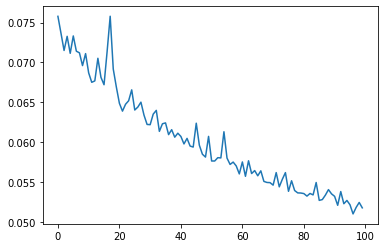

In [125]:
plt.plot(losses)

### Results of black-box

In [30]:
test_leak = np.concatenate((train_check[np.random.permutation(train_check.shape[0])][0:1000], 
                            sample_fake(1000).cpu().detach().numpy()), axis=0)

In [31]:
discriminator.eval()
ans = discriminator(torch.tensor(test_leak).float().cuda()).cpu().detach().numpy().reshape(-1)
labels = np.array([x < 1000 for x in range(2000)], dtype=int)
df = pd.DataFrame({'ans':ans, 'label':labels})
df.head()

,ans,label
0,4.624358,1
1,5.028499,1
2,5.788537,1
3,5.061389,1
4,5.162246,1


In [32]:
recall = df.sort_values(by='ans', ascending=False).iloc[0:1000]['label'].sum() / 1000

In [33]:
print("The recall of the model is: ", recall)

The recall of the model is:  1.0


It is very hard to believe, but this attack is a complete success here. One has to make this network more sustainable to such attacks.

# White-box attack

Suppose an adversary has all the network. Assumption that the discriminator might have been overfit leads an idea that the discriminator could react on samples which were in the train set. 

In [34]:
#'D' is a pretrained discriminator but 'discriminator' is my model
D.eval()
ans = D(torch.tensor(test_leak).float().cuda()).cpu().detach().numpy().reshape(-1)
labels = np.array([x < 1000 for x in range(2000)], dtype=int)
df = pd.DataFrame({'ans':ans, 'label':labels})
df.head()

,ans,label
0,1.0,1
1,1.0,1
2,1.0,1
3,1.0,1
4,1.0,1


In [35]:
recall = df.sort_values(by='ans', ascending=False).iloc[0:1000]['label'].sum() / 1000

In [36]:
print("The recall of the model is: ", recall)

The recall of the model is:  0.939


Surprisingly, the white-box attack works against the DCGAN rather well. 

# Black-box attack without leakages

Suppose leakage in my train_set did not occur. Suppose an adversary is not a PhD on neural network and is not aware of DCGAN. Under those assumptions, we will try to construct a silly GAN (or simply SGAN) which will be learned on <b>generated data</b> as if it were <b>real samples</b>.

At first, we will make some technical work

In [37]:
import os

GDRIVE_PATH = '/data/apsidorenko'
THIS_EXERCISE_PATH = os.path.join(GDRIVE_PATH, "GAN_exercises")
MODELS_HOME = os.path.join(THIS_EXERCISE_PATH, "mnist guns")

In [38]:
os.makedirs(THIS_EXERCISE_PATH, exist_ok=True)
os.makedirs(MODELS_HOME, exist_ok=True)

In [39]:
GENERATOR_FILE = os.path.join(MODELS_HOME, 'generator_hack.pt')
DISCRIMINATOR_FILE = os.path.join(MODELS_HOME, 'discriminator_hack.pt')

In [40]:
import matplotlib.pyplot as plt
import matplotlib

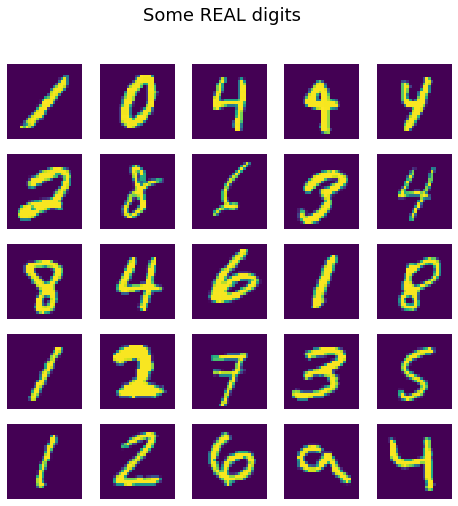

In [41]:
def plot_images(images: np.ndarray,
                nrows: int=5, ncols: int=5,
                shuffle: bool=True,
                title: str="",
                figure: matplotlib.figure.Figure=None) -> matplotlib.figure.Figure:
  """
  Plots a subset of images.
  
  Args:
    images[n_images, n_channels, width, height]: a dataset with images to plot
    nrows: number of images in a plotted row
    ncols: numer of images in a plotted colunm
    shuffle: if True draw a random subset of images, if False -- the first ones
    figure: if not None, it's used for plotting, if None, a new one is created
  
  Returns:
    a figure containing the plotted images
  """
  if shuffle:
    images_to_plot = images[np.random.permutation(len(images))[:nrows*ncols]]
  else:
    images_to_plot = images[:nrows * ncols]
  h, w = images_to_plot.shape[2:]
  if figure is None:
    figure = plt.figure(figsize=(8,8))
  
  axes = figure.subplots(nrows=nrows, ncols=ncols)
  for row_idx, ax_row in enumerate(axes):
    for col_idx, ax in enumerate(ax_row):
      ax.imshow(images_to_plot[row_idx + ncols*col_idx, 0],
                interpolation="none")
      ax.set_axis_off()

  figure.suptitle(title, fontsize=18)
  return figure

plot_images(train, title="Some REAL digits");

Now we are ready to build the SGAN (it means "Silly GAN").

In [42]:
CODE_SIZE = 256
DROPOUT_RATE = 0.2

try:
  generator = torch.load(GENERATOR_FILE)
  discriminator = torch.load(DISCRIMINATOR_FILE)
except FileNotFoundError:
  print('Files have not been found: making new nets\n')
  generator = torch.nn.Sequential(      
      torch.nn.Linear(CODE_SIZE, 256*3*3),
      torch.nn.ELU(),
      torch.nn.Dropout(p=DROPOUT_RATE),
      
      Reshape(256, 3, 3), # 3x3
      torch.nn.Conv2d(256, 128, kernel_size=3, padding=1),
      torch.nn.ELU(),
      torch.nn.Dropout(p=DROPOUT_RATE),
      
      torch.nn.Upsample(scale_factor=2), # 6x6
      
      torch.nn.Conv2d(128, 64, kernel_size=3, padding=1),
      torch.nn.ELU(),
      torch.nn.Dropout(p=DROPOUT_RATE),
      
      torch.nn.ConvTranspose2d(64, 64, kernel_size=3), # 8x8
      torch.nn.ELU(),
      torch.nn.Dropout(p=DROPOUT_RATE),
      
      torch.nn.Upsample(scale_factor=2), # 16x16
      
      torch.nn.Conv2d(64, 32, kernel_size=3, padding=1),
      torch.nn.ELU(),
      torch.nn.Dropout(p=DROPOUT_RATE),
      
      torch.nn.Upsample(scale_factor=2), # 32x32
      torch.nn.Conv2d(32, 16, kernel_size=3, padding=0), # 30x30
      torch.nn.ELU(),
      
      torch.nn.Dropout(p=DROPOUT_RATE),
      torch.nn.Conv2d(16, 8, kernel_size=3, padding=0), # 28x28
      torch.nn.ELU(),
      
      torch.nn.Dropout(p=DROPOUT_RATE),
      torch.nn.ConvTranspose2d(8, 1, kernel_size=1), # 28x28
).cuda()

  discriminator = nn.Sequential(
           #Reshape(1, 28,28),
           torch.nn.Conv2d(1, 8, kernel_size=3, padding=1),
           torch.nn.ELU(),
           torch.nn.Dropout(p=DROPOUT_RATE),
      
            torch.nn.MaxPool2d(2), # 18x18
      
            torch.nn.Conv2d(8, 32, kernel_size=3, padding=1),
            torch.nn.ELU(),
            torch.nn.Dropout(p=DROPOUT_RATE),
      
            torch.nn.MaxPool2d(2), # 9x9
      
            torch.nn.Conv2d(32, 64, kernel_size=3), # 7x7
            torch.nn.ELU(),
            torch.nn.Dropout(p=DROPOUT_RATE),
      
            torch.nn.Conv2d(64, 256, kernel_size=3), # 5x5
            torch.nn.ELU(),
            torch.nn.Dropout(p=DROPOUT_RATE),
      
            torch.nn.Conv2d(256, 512, kernel_size=3), # 3x3
            torch.nn.ELU(),
            torch.nn.Dropout(p=DROPOUT_RATE),
      
             Reshape(512),
             torch.nn.Linear(512, 1)
).cuda()

In [43]:
def sample_fake(batch_size):
  noise = torch.randn(batch_size, CODE_SIZE, device="cuda")
  return generator(noise)

In [44]:
#WARNING: this function gives images made by DCGAN
def sample_images(batch_size):
  noise = torch.randn(batch_size, latent_size, 1, 1, device="cuda")
  return G(noise)

In [45]:
noise_power = 0.2
gradient_penalty = 0.0001

def generator_loss(fake):
  return -logsigmoid(discriminator(
              fake + torch.randn(*fake.shape, device="cuda") * noise_power
          )).mean()
  
  
def discriminator_loss(real, fake):
  return -logsigmoid(discriminator(
              real + torch.randn(*real.shape, device="cuda") * noise_power
          )).mean() - \
          logsigmoid(-discriminator(
              fake + torch.randn(*fake.shape, device="cuda") * noise_power
          )).mean()

def discriminator_penalty(real, size=gradient_penalty):
  scores = discriminator(real)
  grad_params = torch.autograd.grad(scores.mean(), discriminator.parameters(),
                                    create_graph=True)
  penalty = sum((grad**2).sum() for grad in grad_params)
  return penalty * size

In [46]:
optimizer_generator = \
    torch.optim.RMSprop(generator.parameters(), lr=0.001)
optimizer_discriminator = \
    torch.optim.RMSprop(discriminator.parameters(), lr=0.001)

disc_scheduler = torch.optim.lr_scheduler.StepLR(optimizer_discriminator, step_size=10, gamma=0.999)
gen_scheduler = torch.optim.lr_scheduler.StepLR(optimizer_generator, step_size=10, gamma=0.999)

In [47]:
VALIDATION_INTERVAL = 150
SAVE_INTERVAL = 500
DISCRIMINATOR_ITERATIONS_PER_GENEREATOR = 5
BATCH_SIZE=128

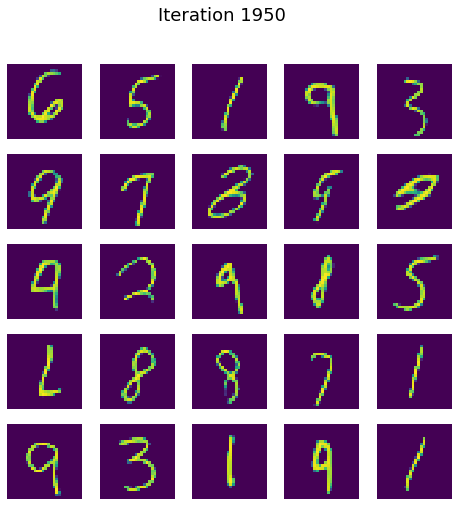

In [53]:
from IPython.display import clear_output
for i in range(2000):
  # Set our models to training mode:
  generator.train()
  discriminator.train()
  gen_scheduler.step()
  disc_scheduler.step()
  
  # Several discriminator updates per step:
  for j in range(DISCRIMINATOR_ITERATIONS_PER_GENEREATOR):
    # Sampling reals and fakes
    real = sample_images(BATCH_SIZE)
    fake = sample_fake(BATCH_SIZE)
    
    # Calculating the loss
    discriminator_loss_this_iter = discriminator_loss(real, fake) + \
                                   discriminator_penalty(real)
    
    # Doing our regular optimization step for the discriminator
    optimizer_discriminator.zero_grad()
    discriminator_loss_this_iter.backward()
    optimizer_discriminator.step()

  # Pass the discriminator loss to Tensorboard for plotting 
  #summary_writer.add_scalar("discriminator loss", discriminator_loss_this_iter,
   #                          global_step=i)

  # Now it's generator's time to learn:
  generator_loss_this_iter = generator_loss(sample_fake(BATCH_SIZE))
  #summary_writer.add_scalar("generator loss", generator_loss_this_iter,
   #                         global_step=i)
  optimizer_generator.zero_grad()
  generator_loss_this_iter.backward()
  optimizer_generator.step()

  if i % SAVE_INTERVAL == 0:
    torch.save(generator, GENERATOR_FILE)
    torch.save(discriminator, DISCRIMINATOR_FILE)
    
  if i % VALIDATION_INTERVAL == 0:
    clear_output(wait=True)
    generator.eval()
    imgs = sample_fake(25).cpu().detach().numpy()
    plot_images(imgs.clip(0, 1), title='Iteration '+str(i));
    plt.show();

### Testing our SGAN

To measure capacities of the net, we will try to distinguish real train data and data generated <b>by the DCGAN</b>. So the function 'sample_imgages' utitlises DCGAN to make images.

In [54]:
test_leak = np.concatenate((train_check[np.random.permutation(train_check.shape[0])][1000:2000], 
                            sample_images(1000).cpu().detach().numpy()), axis=0)

In [55]:
#'D' is a pretrained discriminator but 'discriminator' is a model of an adversary
discriminator.eval()
ans = discriminator(torch.tensor(test_leak).float().cuda()).cpu().detach().numpy().reshape(-1)
labels = np.array([x < 1000 for x in range(2000)], dtype=int)
df = pd.DataFrame({'ans':ans, 'label':labels})
df.head()

,ans,label
0,-2.160482,1
1,-0.682171,1
2,-1.002739,1
3,-1.604780,1
4,-1.652319,1


In [56]:
recall = df.sort_values(by='ans', ascending=False).iloc[0:1000]['label'].sum() / 1000

In [57]:
print("The recall of the model is: ", recall)

The recall of the model is:  0.54


## Learning DCGAN against DCGAN 

Let's try to learn our DCGAN against the given DCGAN. We might be lucky :)

In [85]:
GENERATOR_FILE = os.path.join(MODELS_HOME, 'DCGAN_hacker_generator.pt')
DISCRIMINATOR_FILE = os.path.join(MODELS_HOME, 'DCGAN_hacker_discriminator.pt')

In [101]:
CODE_SIZE = 100
DROPOUT_RATE = 0.2
nc=1
nz=100
ngf=64
ndf=64

try:
  generator = torch.load(GENERATOR_FILE)
  discriminator = torch.load(DISCRIMINATOR_FILE)
except FileNotFoundError:
  print('Files have not been not found: making new nets\n')
  generator = torch.nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2,     ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d( ngf,nc, kernel_size=1, stride=1, padding=2, bias=False),
            nn.Tanh()
        ).cuda()

  discriminator = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, 1, 4, 2, 1, bias=False),
            #nn.Sigmoid()
        ).cuda()

Files have not been not found: making new nets



In [102]:
def sample_fake(batch_size):
  noise = torch.randn(batch_size, CODE_SIZE, 1, 1, device="cuda")
  return generator(noise)

In [103]:
#WARNING: this function gives images made by DCGAN
def sample_images(batch_size):
  noise = torch.randn(batch_size, latent_size, 1, 1, device="cuda")
  return G(noise)

In [104]:
noise_power = 0.2
gradient_penalty = 0.0001

def generator_loss(fake):
  return -logsigmoid(discriminator(
              fake + torch.randn(*fake.shape, device="cuda") * noise_power
          )).mean()
  
  
def discriminator_loss(real, fake):
  return -logsigmoid(discriminator(
              real + torch.randn(*real.shape, device="cuda") * noise_power
          )).mean() - \
          logsigmoid(-discriminator(
              fake + torch.randn(*fake.shape, device="cuda") * noise_power
          )).mean()

def discriminator_penalty(real, size=gradient_penalty):
  scores = discriminator(real)
  grad_params = torch.autograd.grad(scores.mean(), discriminator.parameters(),
                                    create_graph=True)
  penalty = sum((grad**2).sum() for grad in grad_params)
  return penalty * size

In [105]:
optimizer_generator = \
    torch.optim.RMSprop(generator.parameters(), lr=0.001)
optimizer_discriminator = \
    torch.optim.RMSprop(discriminator.parameters(), lr=0.001)

disc_scheduler = torch.optim.lr_scheduler.StepLR(optimizer_discriminator, step_size=10, gamma=0.999)
gen_scheduler = torch.optim.lr_scheduler.StepLR(optimizer_generator, step_size=10, gamma=0.999)

In [106]:
VALIDATION_INTERVAL = 150
SAVE_INTERVAL = 500
DISCRIMINATOR_ITERATIONS_PER_GENEREATOR = 5
BATCH_SIZE=128

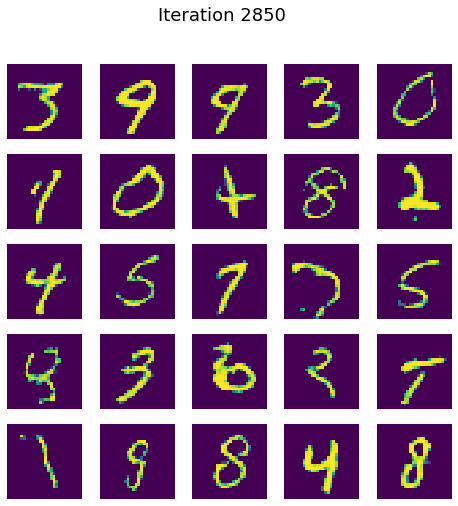

In [107]:
from IPython.display import clear_output
for i in range(3000):
  # Set our models to training mode:
  generator.train()
  discriminator.train()
  gen_scheduler.step()
  disc_scheduler.step()
  
  # Several discriminator updates per step:
  for j in range(DISCRIMINATOR_ITERATIONS_PER_GENEREATOR):
    # Sampling reals and fakes
    real = sample_images(BATCH_SIZE)
    fake = sample_fake(BATCH_SIZE)
    
    # Calculating the loss
    discriminator_loss_this_iter = discriminator_loss(real, fake) + \
                                   discriminator_penalty(real)
    
    # Doing our regular optimization step for the discriminator
    optimizer_discriminator.zero_grad()
    discriminator_loss_this_iter.backward()
    optimizer_discriminator.step()

  # Pass the discriminator loss to Tensorboard for plotting 
  #summary_writer.add_scalar("discriminator loss", discriminator_loss_this_iter,
   #                          global_step=i)

  # Now it's generator's time to learn:
  generator_loss_this_iter = generator_loss(sample_fake(BATCH_SIZE))
  #summary_writer.add_scalar("generator loss", generator_loss_this_iter,
   #                         global_step=i)
  optimizer_generator.zero_grad()
  generator_loss_this_iter.backward()
  optimizer_generator.step()

  if i % SAVE_INTERVAL == 0:
    torch.save(generator, GENERATOR_FILE)
    torch.save(discriminator, DISCRIMINATOR_FILE)
    
  if i % VALIDATION_INTERVAL == 0:
    clear_output(wait=True)
    generator.eval()
    imgs = sample_fake(25).cpu().detach().numpy()
    plot_images(imgs.clip(0, 1), title='Iteration '+str(i));
    plt.show();

### Trying to hack 

In [108]:
test_leak = np.concatenate((train_check[np.random.permutation(train_check.shape[0])][1000:2000], 
                            sample_images(1000).cpu().detach().numpy()), axis=0)

In [109]:
#'D' is a pretrained discriminator but 'discriminator' is a model of an adversary
discriminator.eval()
ans = discriminator(torch.tensor(test_leak).float().cuda()).cpu().detach().numpy().reshape(-1)
labels = np.array([x < 1000 for x in range(2000)], dtype=int)
df = pd.DataFrame({'ans':ans, 'label':labels})
df.head()

,ans,label
0,-25.105755,1
1,-33.722935,1
2,-30.796804,1
3,-21.933630,1
4,-29.608528,1


In [110]:
recall = df.sort_values(by='ans', ascending=True).iloc[0:1000]['label'].sum() / 1000
print("The recall of the model is: ", recall)

The recall of the model is:  1.0


Surprisingly, this net reacts on train entries differently. Yet the result is great.

# Summary

<b> DCGAN is a perfect example of adversarial attacks. It means that there is a room for improvements. On the other hand, plain and naive networks are a great deal more resistant. </b>